# 说明---三个有效秩

为了更好的反应不同的scale对应的有效秩的大小和变化情况,希望可以在每一个scale下多做几次计算,这样的话,可以通过取平均等方法消除不确定的噪音

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# 首先加载自己的支持函数
from support_code.get_rank_cpu_0904 import get_Effective_Ranks, Effective_Ranks
from support_code.load_dataset import get_data_loader
from support_code.MLP import MLP
from support_code.scale_ranks import get_rank
# 然后加载其他可能需要的库
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import CIFAR10
import numpy as np
from torch.optim.lr_scheduler import LambdaLR   # 这个用来实现学习率的线性变化
import os
# 指定存储图像的目录
output_dir = '观察ranks'

# 如果目录不存在，创建它
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [46]:
import pandas as pd

# ------------------------------------训练开始前的基本设置---------------------------------------------------
# 设置设备
device_cuda = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 创建一个全零的(9, 3, 5)张量
result_tensor = torch.zeros((9, 5, 4), dtype=torch.float32)
# ---------------------------------- 设置结束----------------------------------------------------------------------------------
# 第一个维度
scales = [i / 10.0 for i in range(1, result_tensor.shape[0]+1)]
i = 0

# 创建三维DataFrame
for scale in scales:
    print("--------------------开始scale={}的情况---------------------".format(scale), "\n")
    train_loader, valid_loader, test_loader = get_data_loader(scale, valid_scale=0.1)
    print("首先得到了有效秩的情况 \n")
    for j in range(result_tensor.shape[1]):
        # 假设get_rank返回的4个数字是[rk_max_index,rk_max_value, Rk_value_max_rk_index, rk[0]]
        num1, num2, num3, num4 = get_rank(scale=scale, device=device_cuda, train_loader=train_loader)

        # 使用索引将这4个数字填充到张量的第三个维度
        result_tensor[i, j, :] = torch.tensor([num1, num2, num3, num4], dtype=torch.float32)
    i += 1

print(result_tensor)


--------------------开始scale=0.1的情况--------------------- 

Files already downloaded and verified
Files already downloaded and verified
首先得到了有效秩的情况 

--------------------开始scale=0.2的情况--------------------- 

Files already downloaded and verified
Files already downloaded and verified
首先得到了有效秩的情况 

--------------------开始scale=0.3的情况--------------------- 

Files already downloaded and verified
Files already downloaded and verified
首先得到了有效秩的情况 

--------------------开始scale=0.4的情况--------------------- 

Files already downloaded and verified
Files already downloaded and verified
首先得到了有效秩的情况 

--------------------开始scale=0.5的情况--------------------- 

Files already downloaded and verified
Files already downloaded and verified
首先得到了有效秩的情况 

--------------------开始scale=0.6的情况--------------------- 

Files already downloaded and verified
Files already downloaded and verified
首先得到了有效秩的情况 

--------------------开始scale=0.7的情况--------------------- 

Files already downloaded and verified
Files already do

Combined plot saved as '观察ranks\ranks单独.png'


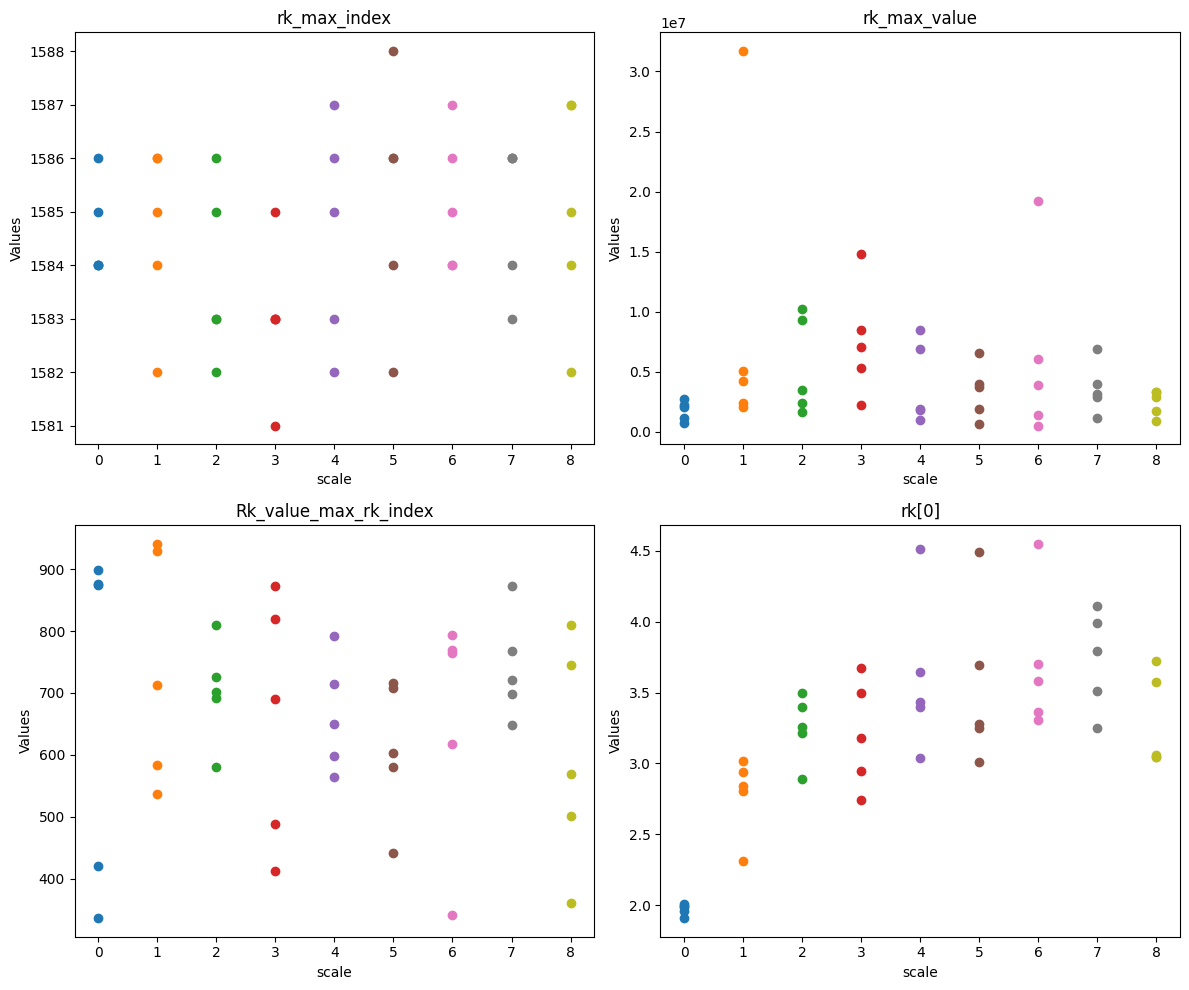

In [53]:
# 假设 result_tensor 已经创建，形状为 (9, 3, 4)

# 获取 result_tensor 中的数据
data = result_tensor.numpy()  # 转换为 NumPy 数组

# 创建一个列表来保存不同类型的点的标签
legend_labels = ['rk_max_index', 'rk_max_value', 'Rk_value_max_rk_index', 'rk[0]']

# 创建一个颜色和形状的列表以区分不同的点
colors = ['b', 'g', 'r', 'c']  # 不同颜色
markers = ['o', 's', 'D', '^']  # 不同形状

# 创建一个图形，分为4个子图
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 针对每种数据类型创建子图
for i in range(result_tensor.shape[2]):
    ax = axes[i // 2, i % 2]  # 获取当前子图
    ax.set_title(legend_labels[i])  # 子图标题
    for j in range(result_tensor.shape[0]):
        x = [j] * result_tensor.shape[1]  # 同一横坐标位置
        y = data[j, :, i]  # 不同数据点的值
        ax.scatter(x, y)

    # 添加图例
    # ax.legend()

# 设置横坐标和纵坐标标签
for ax in axes.flat:
    ax.set(xlabel='scale', ylabel='Values')

# 调整子图布局
plt.tight_layout()
# 保存整个大图
output_filename = os.path.join(output_dir, "ranks单独.png")
plt.savefig(output_filename)
print(f"Combined plot saved as '{output_filename}'")

# 显示图形
plt.show()


Combined plot saved as '观察ranks\ranks平均.png'


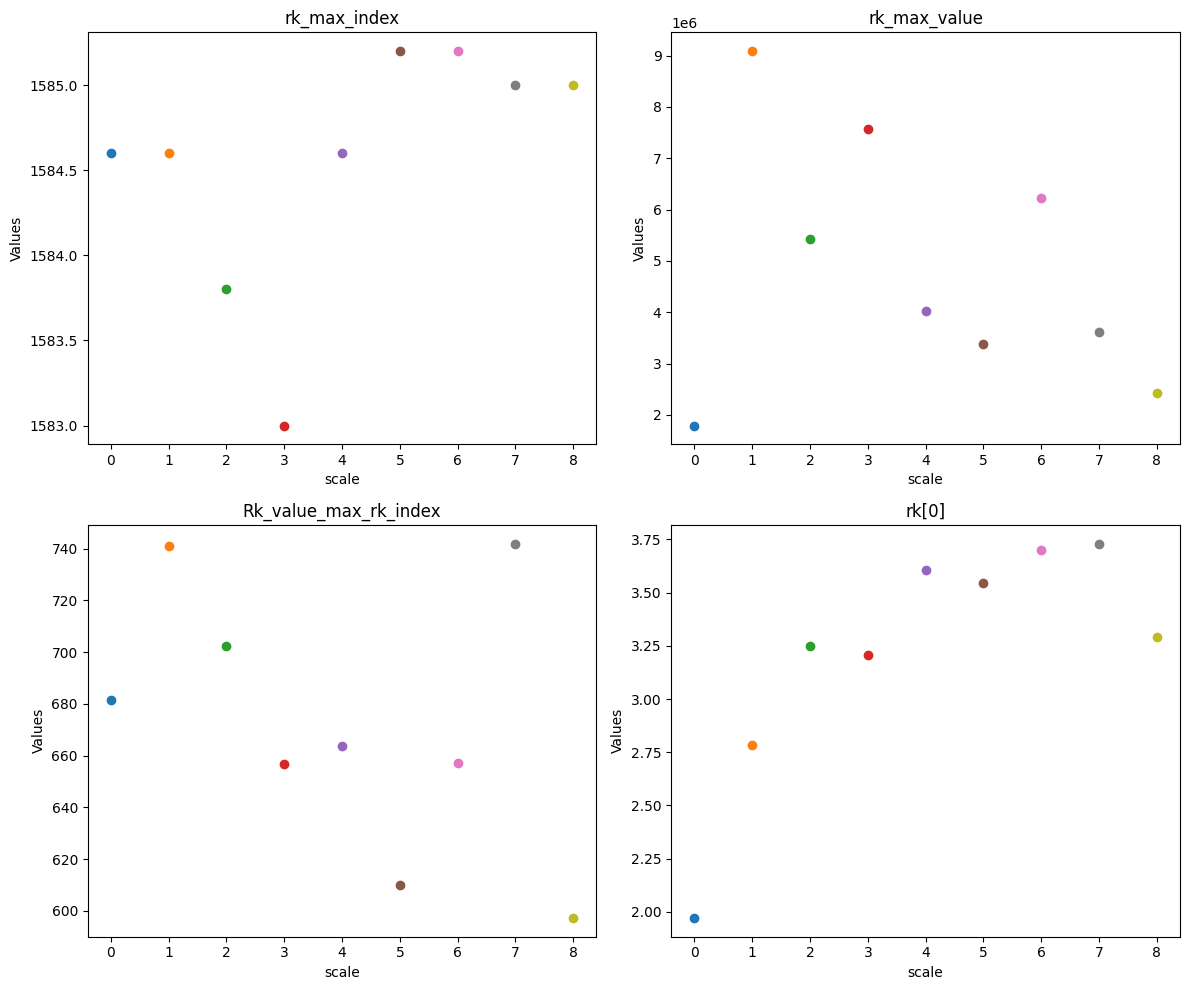

In [55]:
# 假设 result_tensor 已经创建，形状为 (9, 3, 4)

# 获取 result_tensor 中的数据
data = result_tensor.numpy()  # 转换为 NumPy 数组

# 创建一个列表来保存不同类型的点的标签
legend_labels = ['rk_max_index', 'rk_max_value', 'Rk_value_max_rk_index', 'rk[0]']

# 创建一个颜色和形状的列表以区分不同的点
colors = ['b', 'g', 'r', 'c']  # 不同颜色
markers = ['o', 's', 'D', '^']  # 不同形状

# 创建一个图形，分为4个子图
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 针对每种数据类型创建子图
for i in range(result_tensor.shape[2]):
    ax = axes[i // 2, i % 2]  # 获取当前子图
    ax.set_title(legend_labels[i])  # 子图标题
    for j in range(result_tensor.shape[0]):
        x = [j]   # 同一横坐标位置
        y = data[j, :, i].mean()  # 不同数据点的值
        ax.scatter(x, y)

    # 添加图例
    # ax.legend()

# 设置横坐标和纵坐标标签
for ax in axes.flat:
    ax.set(xlabel='scale', ylabel='Values')

# 调整子图布局
plt.tight_layout()
# 保存整个大图
output_filename = os.path.join(output_dir, "ranks平均.png")
plt.savefig(output_filename)
print(f"Combined plot saved as '{output_filename}'")

# 显示图形
plt.show()
